# Importing all the important Libraries

In [47]:
#Importing Important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.fft import fft, ifft,fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data Collection from Yahoo finance(Free open source)

In [48]:
# Defining the ticker symbol for AMAZON 
ticker_symbol = 'AMZN'

# Get data for the ticker symbol
df = yf.download(ticker_symbol,start = '2020-01-01' ,end ='2024-08-16').iloc[::-1]
#Change date index to datetime type
df.index = pd.to_datetime(df.index)
df = df.iloc[::-1]

[*********************100%%**********************]  1 of 1 completed


# Plotting the data

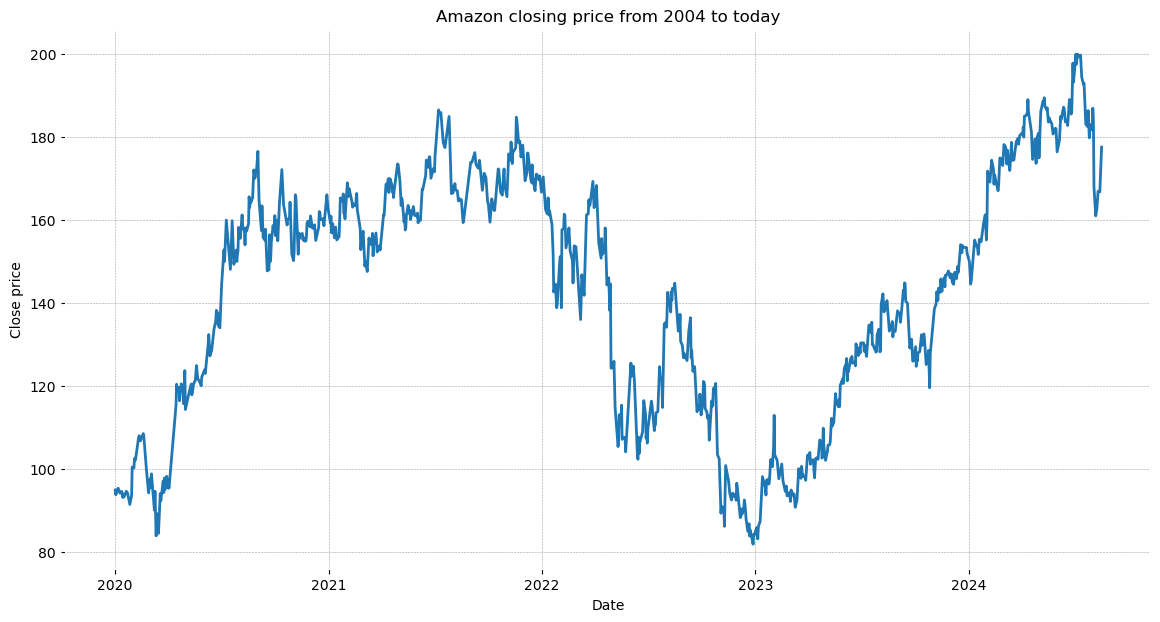

In [49]:
#Plotting lineplot from 2004 to todays date
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label = "AMZN closing price")
plt.title('Amazon closing price from 2004 to today')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

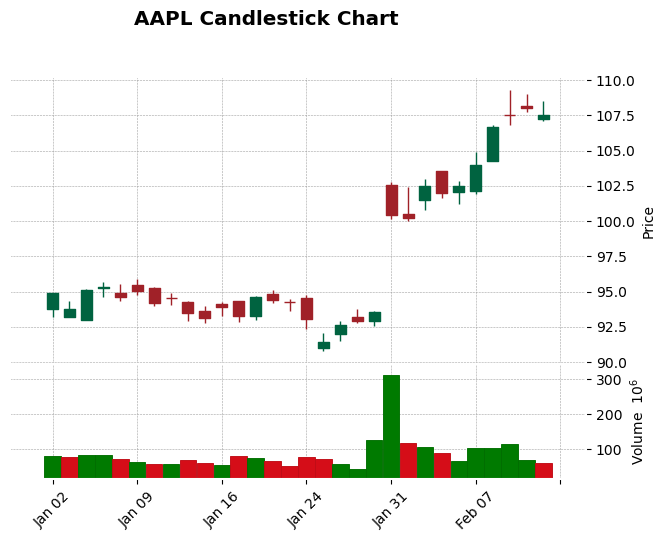

In [50]:
#candlestick chart for last 30 days to find out any recurring pattern 
import mplfinance as mpf
mpf.plot(df.iloc[0:30], type='candle', style='charles', title='AAPL Candlestick Chart', volume=True)


[]

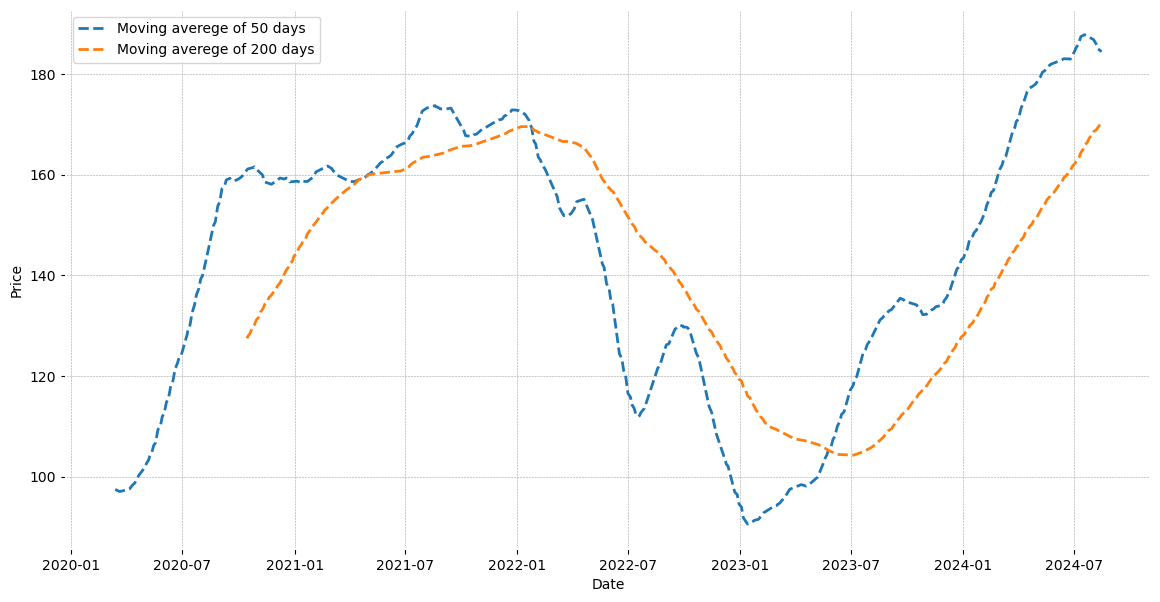

In [51]:
#Visualisation moving average for the data
close_mean_50 = df['Close'].rolling(window = 50).mean()
close_mean_200 = df['Close'].rolling(window = 200).mean()

#Plotting the data
plt.figure(figsize = (14,7))
plt.plot(close_mean_50 ,label = "Moving averege of 50 days",linestyle ='--')
plt.plot(close_mean_200 ,label = "Moving averege of 200 days",linestyle ='--')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.plot()

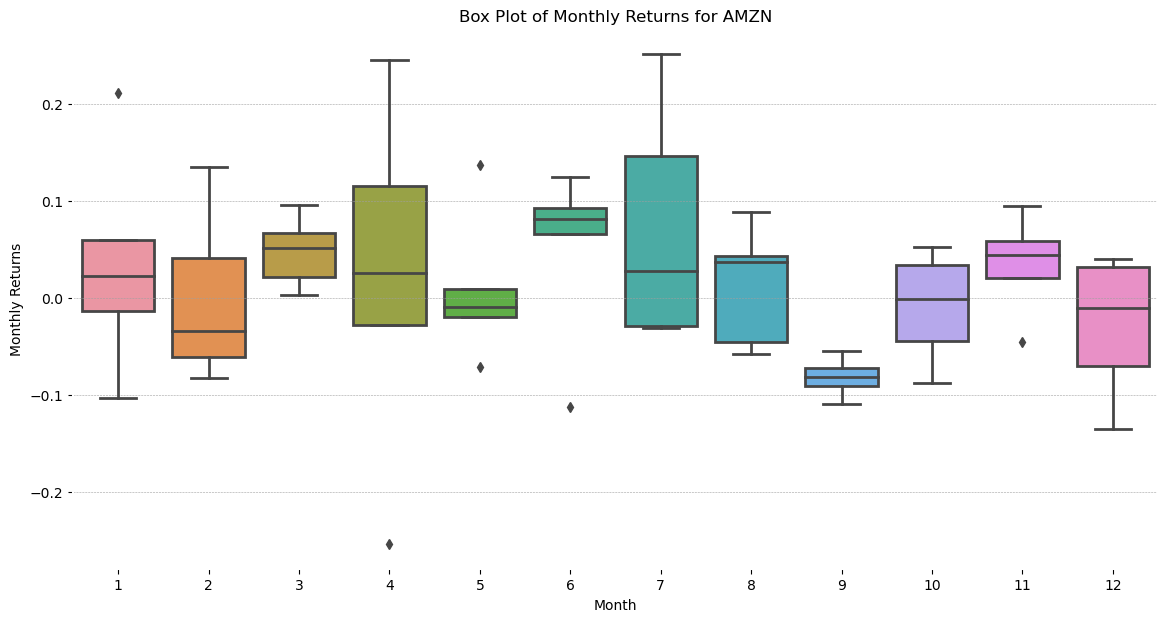

In [52]:
#  Box Plot of Monthly Returns
returns = df['Close'].pct_change().dropna()
returns_df = returns.to_frame()
returns_df['YearMonth'] = returns_df.index.to_period('M')
monthly_returns = returns_df.groupby('YearMonth')['Close'].sum()

#Plotting the figure
plt.figure(figsize=(14, 7))
sns.boxplot(x=monthly_returns.index.month, y=monthly_returns)
plt.title('Box Plot of Monthly Returns for AMZN')
plt.xlabel('Month')
plt.ylabel('Monthly Returns')
plt.show()

# Starting fourier transformation



C:\Users\dixit\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


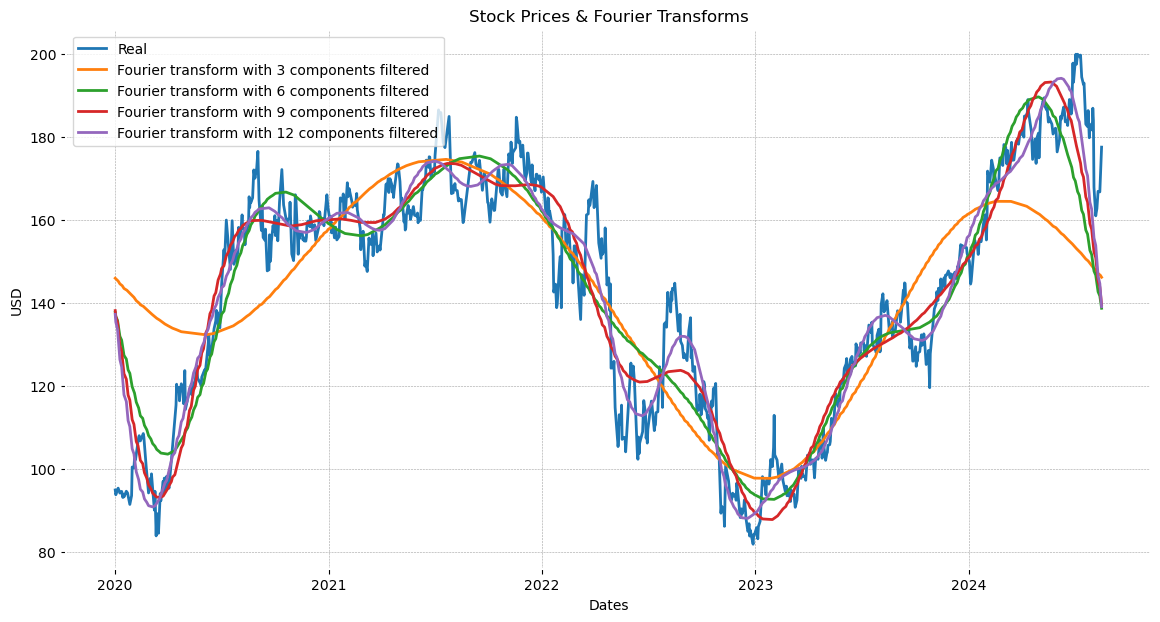

In [53]:
dataset_ex_df = df[['Close']]
# Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(data_FT['Close'].values)
fft_df = pd.DataFrame({
    'fft': close_fft,
    'absolute': np.abs(close_fft),
    'angle': np.angle(close_fft)
})

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(data_FT.index, data_FT['Close'], label='Real')

# Plot reconstructions with filtered frequencies
for num in [3, 6, 9,12]:
    fft_list_filtered = np.copy(close_fft)
    fft_list_filtered[num:-num] = 0  # Zero out some frequencies
    filtered_data = np.fft.ifft(fft_list_filtered)
    plt.plot(data_FT.index, filtered_data, label=f'Fourier transform with {num} components filtered')

plt.xlabel('Dates')
plt.ylabel('USD')
plt.title('Stock Prices & Fourier Transforms')
plt.legend()
plt.show()

# Feature enginering

In [54]:
# Calculate EMA(Exponential moving average)
def ema(close, period):
    return close.ewm(span = period, adjust = False).mean()

In [55]:
# Calculate RSI (Relative Strength Index)
def rsi(close, period):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [56]:
# Calculate MACD(Moving Average Convergence Divergence)
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    return macd_line

In [57]:
# Calculate OBV(On-Balance Volume)
def obv(close, volume):
    obv = np.where(close > close.shift(),volume,
                   np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv


#Note 
orignal period for rsi is 14 but here is 10 so change it if something burts

In [58]:
#Adding technichal indicaters to our original dataset

#Copying the origional dataset to add extra features
tech_df = df.copy()

#Adding volumne and close of one day before to make all the features
tech_df['y_Volume']= df['Volume'].shift(1)
tech_df['y_Close']= df['Close'].shift(1)

#Calculating features for exponential moving average with period 10,20 and 50
tech_df['ema10'] = ema(tech_df['y_Close'],10)
tech_df['ema20'] = ema(tech_df['y_Close'],20)
tech_df['ema50'] = ema(tech_df['y_Close'],50)

#Calculating feature for RSI for 10 days
tech_df['rsi'] = rsi(tech_df['y_Close'],10)

#Calculating feature for MACD
tech_df['macd'] = macd(tech_df['y_Close'])

#Calculating feature for OBV
tech_df['obv'] = obv(tech_df['y_Close'], tech_df['y_Volume'])

#Calculating features for fourier teansform
# Reset index of fft_df and add the original index as a new column
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(tech_df.index)

# Set the new datetime index
fft_df.set_index('index', inplace=True)

# Create DataFrames for the real and imaginary parts of the FFT
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Adding fourier transform features in technichal indicater dataframe by concatination
tech_df = pd.concat([tech_df,fft_df_real,fft_df_imag ],axis = 1)
#extracting important fearures and removing some initial values because of 'NaN'
tech_df = tech_df[['Close','Open','y_Close','y_Volume','ema10','ema20','ema50','rsi','macd','obv','Fourier_real','Fourier_imag']][20:]
#Dictionary to maintain all the results records
results ={}


In [59]:
#Splitting the data feature and target
y =tech_df[['Close']]
x =tech_df.drop(columns ='Close')
trainlen = int(len(x)*0.8)
xtrain,ytrain = x[:trainlen],y[:trainlen]
xtest,ytest = x[trainlen:],y[trainlen:]

In [60]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

xtrain_scaled = scaler_x.fit_transform(xtrain)
xtest_scaled = scaler_x.transform(xtest)

ytrain_scaled = scaler_y.fit_transform(ytrain.values.reshape(-1, 1)).flatten()
#Copying some values for future use
xtrain_scaled_copy = xtrain_scaled.copy()
ytrain_scaled_copy = ytrain_scaled.copy()
xtest_scaled_copy = xtest_scaled.copy()
ytest_copy = ytest.copy()


In [61]:
#A function to predict how many correct guesses a model made and how much profi
def rightWrongCheck(ytest,ypred,xtest):
    ytest = ytest.copy()
    ytest['pd'] = ypred['Close'] - xtest['Open'] 
    ytest['od'] = ytest['Close'] - xtest['Open']  

    right = 0
    profit = 0
    wrong = 0
    for i in range(0,len(ytest)):
        if((ytest['pd'][i] * ytest['od'][i]) > 0):
            right = right +1
            profit = profit + abs(ytest['od'][i])
            continue
        wrong = wrong +1
        profit = profit - abs(ytest['od'][i])
    return right,wrong,profit

In [62]:
#Fucntion for evaluating for all models
def modelEvaluater(name,ytest,ypred):
    
    # Evaluate the model
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    
    right,wrong,profit = rightWrongCheck(ytest,ypred,xtest)
    print(f'right : {right} \nwrong : {wrong} \nprofit : {profit}')
    
    results[name] = {'mse':mse,'r2':r2,'right':right,'wrong': wrong,'profit' :profit}
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ytest, label='True Values')
    plt.plot(ypred, label='Predictions', color='red')
    plt.legend()
    plt.title(f'Stock Market Predictions using {name}')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.show()


# Linear Regression

Mean Squared Error: 5.595635784612792
R-squared: 0.9874701904116792
right : 105 
wrong : 124 
profit : -56.30992889404297


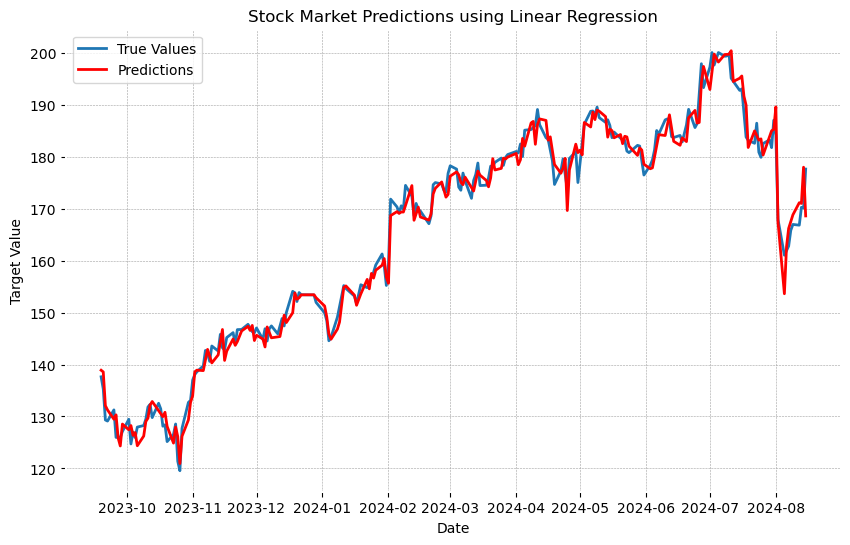

In [63]:
#Create liner regression model object
model = LinearRegression()

#Fitting data to model
model.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = model.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater("Linear Regression",ytest,ypred)




# Polynomeal regressor

Mean Squared Error: 5.076632857582586
R-squared: 0.9886323475108513
right : 121 
wrong : 108 
profit : 28.050025939941406


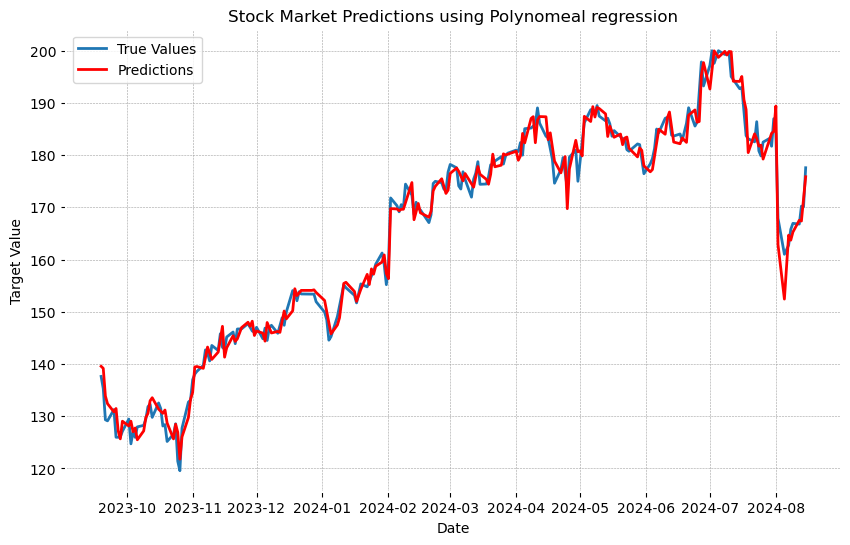

In [64]:
# Degree of the polynomial
degree = 2

# Polynomial modeling of data
poly_features = PolynomialFeatures(degree=degree)
xtrain_poly = poly_features.fit_transform(xtrain[['y_Close','y_Volume','Open','ema10','ema20','ema50']])
xtest_poly = poly_features.transform(xtest[['y_Close','y_Volume','Open','ema10','ema20','ema50']])

#Creating polynomial Regression object
polynomial_regression_model = LinearRegression()

#Fitting data to model
polynomial_regression_model.fit(xtrain_poly,ytrain)

#Making predictions
ypred = polynomial_regression_model.predict(xtest_poly)

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Polynomeal regression',ytest,ypred)

# Decesion Tree Regressor

Mean Squared Error: 30.65277380047484
R-squared: 0.931361969603174
right : 109 
wrong : 120 
profit : -8.990074157714844


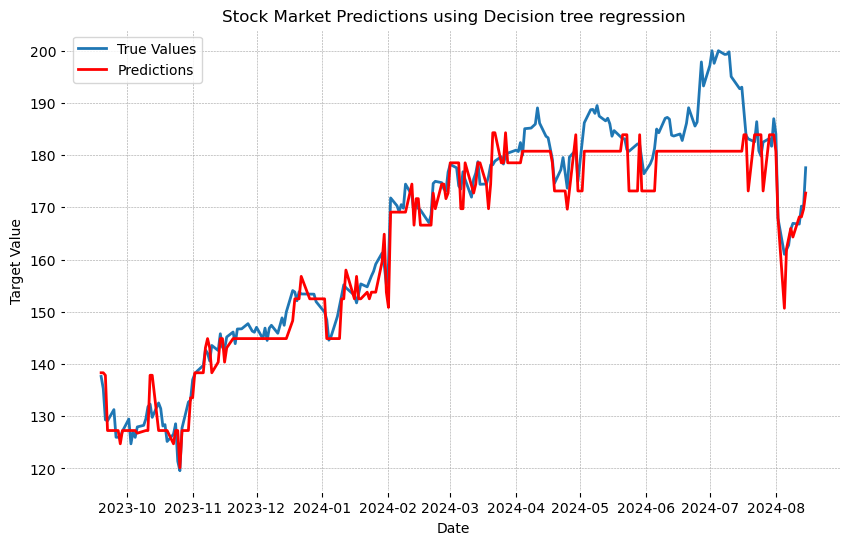

In [65]:
#Creating decision tree object with limiting max depth 7
tree = DecisionTreeRegressor(max_depth=7)

#Fitting data to model
tree.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = tree.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Decision tree regression',ytest,ypred)

# Random Forest Regressor

Mean Squared Error: 22.41605369678811
R-squared: 0.9498057244335522
right : 118 
wrong : 111 
profit : 7.370048522949219


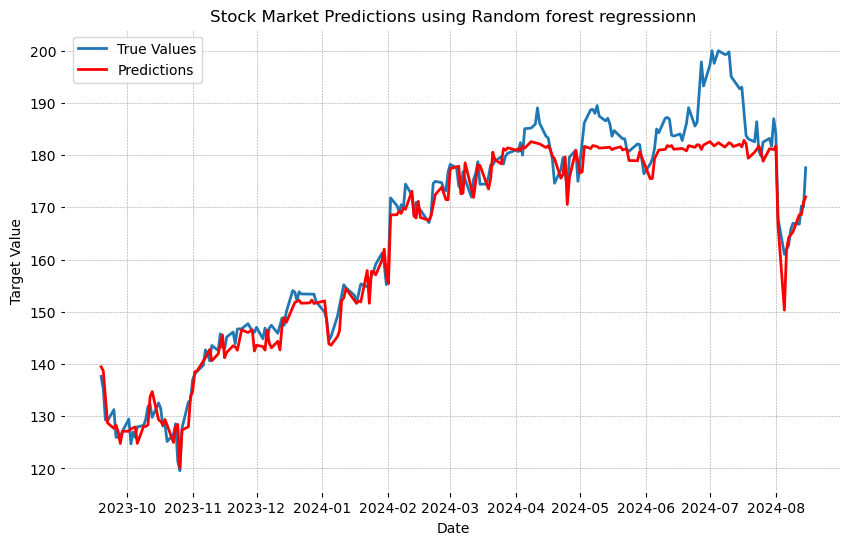

In [66]:
#Creating random forest object
rfr = RandomForestRegressor(random_state=42)

#Fitting data to model
rfr.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled = rfr.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Random forest regressionn',ytest,ypred)

# Gradient boost regressor

Mean Squared Error: 19.25284822695296
R-squared: 0.9568888091358765
right : 104 
wrong : 125 
profit : -46.110008239746094


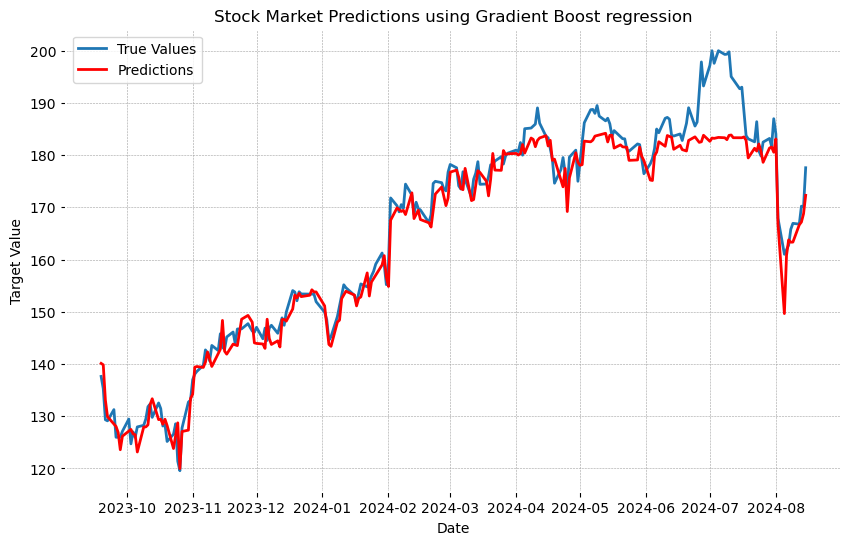

In [67]:
#Creating gradient boost object
gradient_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

#Fitting data to model
gradient_boost.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled =gradient_boost.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater('Gradient Boost regression',ytest,ypred)



# Support Vector Regressor(SVR)

Mean Squared Error: 826.6301106502897
R-squared: -0.8509992939323279
right : 105 
wrong : 124 
profit : -22.270042419433594


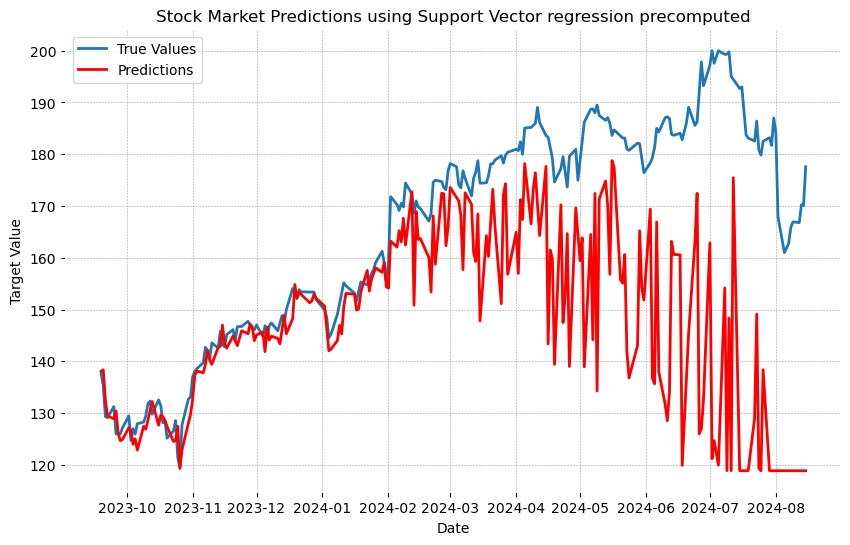

In [68]:
#Setting up kernet value
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
k = kernel[4]
#Creating svr object
svr = SVR(kernel= k)
svr = SVR()

#Fitting data to model
svr.fit(xtrain_scaled,ytrain_scaled)

#Making predictions
ypred_scaled =svr.predict(xtest_scaled)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

modelEvaluater(f'Support Vector regression {k}',ytest,ypred)

# ARIMA Model

Mean Squared Error: 5.556973469043873
R-squared: 0.9875567634966633
right : 107 
wrong : 122 
profit : -54.92992401123047


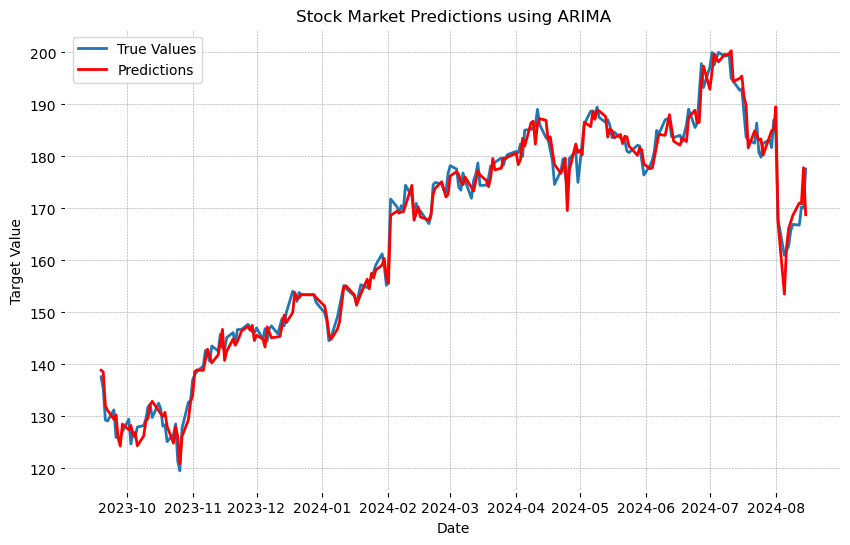

In [69]:
#Making model object
arima = ARIMA(endog = ytrain_scaled_copy , exog = xtrain_scaled_copy , order = (1,0,0)).fit()

#Predincting data
ypred_scaled = arima.forecast(steps = len(xtest_scaled_copy) ,exog = xtest_scaled_copy)

# Inverse transform the predictions
ypred = scaler_y.inverse_transform(ypred_scaled.reshape(-1, 1)).flatten()

#Converting ypred to a dataframe for comparision with tyest
ypred = pd.DataFrame(ypred , columns = ['Close'] ,index = ytest.index)

#evaluate model
modelEvaluater('ARIMA',ytest,ypred)


# LSTM Model

In [93]:
x_scaler_lstm = StandardScaler()
y_scaler_lstm = StandardScaler()
x_lstm= x_scaler_lstm.fit_transform(tech_df.drop(columns ='Close'))
y_lstm = y_scaler_lstm.fit_transform(tech_df[['Close']])

In [94]:
# Create sequences of data for the LSTM model
def create_sequences(xtrain_scaled,ytrain_scaled,seq_length):
    xs, ys = [], []
    for i in range(len(xtrain_scaled) - seq_length):
        x = xtrain_scaled[i:i+seq_length]
        y = ytrain_scaled[i+seq_length]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [95]:
SEQ_LENGTH = 10  # Sequence length can be adjusted
X,y = create_sequences(x_lstm,y_lstm , SEQ_LENGTH)

In [96]:
# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [97]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

In [98]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/10
906/906 [==============================] - 22s 15ms/step - loss: 0.0867
Epoch 2/10
906/906 [==============================] - 10s 11ms/step - loss: 0.0649
Epoch 3/10
906/906 [==============================] - 13s 14ms/step - loss: 0.0590
Epoch 4/10
906/906 [==============================] - 11s 12ms/step - loss: 0.0505
Epoch 5/10
906/906 [==============================] - 13s 14ms/step - loss: 0.0506
Epoch 6/10
906/906 [==============================] - 11s 12ms/step - loss: 0.0485
Epoch 7/10
906/906 [==============================] - 12s 13ms/step - loss: 0.0452
Epoch 8/10
906/906 [==============================] - 8s 9ms/step - loss: 0.0447
Epoch 9/10
906/906 [==============================] - 9s 10ms/step - loss: 0.0426
Epoch 10/10
8/8 [==============================] - 4s 19ms/step


In [99]:
#Inverse transform predicted and scaled values
y_pred_unscaled = y_scaler_lstm.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_unscaled = y_scaler_lstm.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [100]:
# making predicted values and orignal values compatible for modelEvaluater() function by converting that to a dataframe  
len_lstm_test = len(y_pred_unscaled) 
total_len = len(tech_df)
xtest =tech_df[['Open','Close']].iloc[(total_len-len_lstm_test):]

xtest['Close_ytest'] = y_test_unscaled
ytest = xtest[['Close']]
ypred = pd.DataFrame(y_pred_unscaled , index=  ytest.index ,columns = ['Close']) 

Mean Squared Error: 82.97182658762519
R-squared: 0.8128068794049732
right : 111 
wrong : 116 
profit : 40.099937438964844


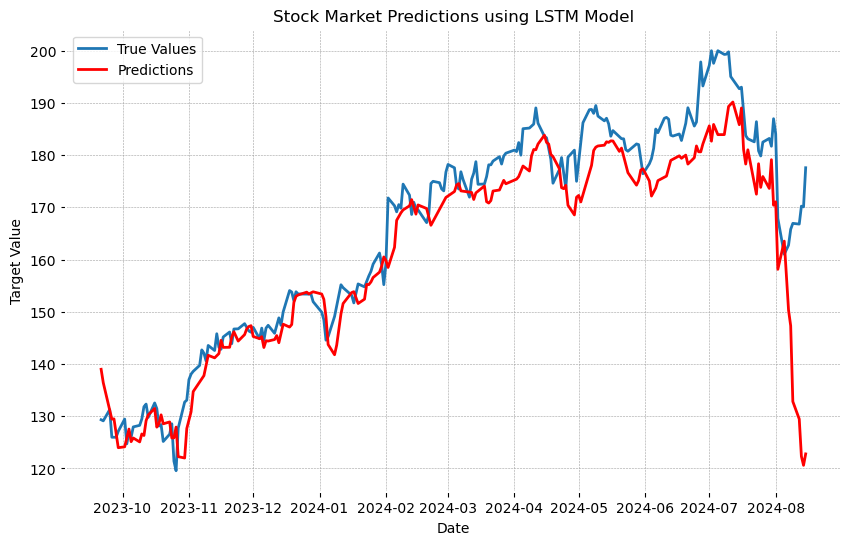

In [101]:
#Nodel evaluation
modelEvaluater("LSTM Model",ytest,ypred)

# Adding Logistic Regression to predict upward or downward trend

In [102]:
#Copying from main dataframe and making new target called 'target' that is 0 when (Open>Close) and 1 when (Open<Close)
log_tech_df = tech_df.copy()
log_tech_df['target'] = (log_tech_df['Open'] > log_tech_df['Close']).astype(int)

In [103]:
#Splitting the data feature and target
log_y =log_tech_df[['target']]
log_x =log_tech_df.drop(columns =['Close','target'])
log_trainlen = int(len(x)*0.8)
log_xtrain,log_ytrain = log_x[:log_trainlen],log_y[:log_trainlen]
log_xtest,log_ytest = log_x[log_trainlen:],log_y[log_trainlen:]

#making another xtest with 'Close' for future accuracy checking
log_xtest_test =log_tech_df[log_trainlen:]

In [104]:
#Scaling the data
log_scaler_x = StandardScaler()
log_scaler_y = StandardScaler()

log_xtrain_scaled = log_scaler_x.fit_transform(log_xtrain)
log_xtest_scaled = log_scaler_x.transform(log_xtest)


In [105]:
#Making model obect
log_reg = LogisticRegression()
#Fitting data to the model
log_reg.fit(log_xtrain_scaled,log_ytrain)
#Making predictions
log_ypred = log_reg.predict(log_xtest_scaled)

log_ypred = pd.DataFrame(log_ypred , columns = ['Close'] ,index = log_ytest.index)

C:\Users\dixit\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
#Model_ evaluation
conf_matrix = confusion_matrix(log_ytest, log_ypred)
accuracy = accuracy_score(log_ytest, log_ypred)
class_report = classification_report(log_ytest, log_ypred)

In [107]:
# making a function that tracks profit according to confusion matrix
def logProfit(log_ypred,log_xtest_test,log_ytest):
    #print('In')
    profit = 0
    for i in range(0,len(log_ypred)):
        #print(i,"Start")
        if(log_ytest.iloc[i].target == log_ypred.iloc[i].Close):
            profit = profit + abs(log_xtest_test.iloc[i].Close - log_xtest_test.iloc[i].Open)
            continue
        profit = profit - abs(log_xtest_test.iloc[i].Close - log_xtest_test.iloc[i].Open)
        #print(i,"End")
    #print('Out')
    return profit

In [108]:
#Getting that profit
log_profit = logProfit(log_ypred,log_xtest_test,log_ytest)

In [109]:
#Adding results of logistic regression to the results map
results["Logistic Regression"] = {'mse': None,
  'r2': None,
  'right': conf_matrix[0][0] + conf_matrix[1][1],
  'wrong': conf_matrix[0][1] + conf_matrix[1][0],
  'profit': log_profit 
}
#Adding results of lag Llama to the results map. Code at "lAG_llama_IMPORTANT_FEATURES.ipynb"
results["Lag Llama"] = {'mse': 28.148832321166992,
  'r2':  0.9082311254479797,
  'right': 106,
  'wrong': 94,
  'profit': 27.509918212890625 
}


In [110]:
#Converting results map to a dataframe
results_df = pd.DataFrame(results).T
results_df

,mse,r2,right,wrong,profit
Linear Regression,5.595636,0.987470,105.0,124.0,-56.309929
Polynomeal regression,5.076633,0.988632,121.0,108.0,28.050026
Decision tree regression,30.652774,0.931362,109.0,120.0,-8.990074
Random forest regressionn,22.416054,0.949806,118.0,111.0,7.370049
Gradient Boost regression,19.252848,0.956889,104.0,125.0,-46.110008
Support Vector regression precomputed,826.630111,-0.850999,105.0,124.0,-22.270042
ARIMA,5.556973,0.987557,107.0,122.0,-54.929924
LSTM Model,82.971827,0.812807,111.0,116.0,40.099937
Logistic Regression,NaN,NaN,117.0,112.0,-16.609856
Lag Llama,28.148832,0.908231,106.0,94.0,27.509918


# Visualise Result Map

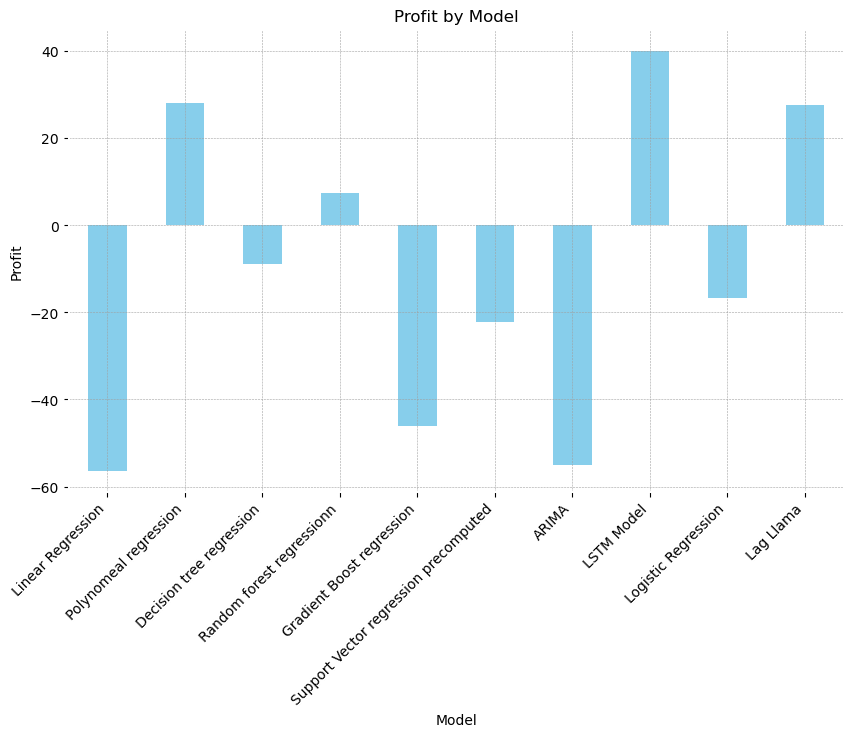

In [111]:
# Bar plot for profits
plt.figure(figsize=(10, 6))
results_df['profit'].plot(kind='bar', color='skyblue')
plt.title('Profit by Model')
plt.ylabel('Profit')
plt.xlabel('Model')
plt.xticks(rotation=45, ha="right")
plt.show()

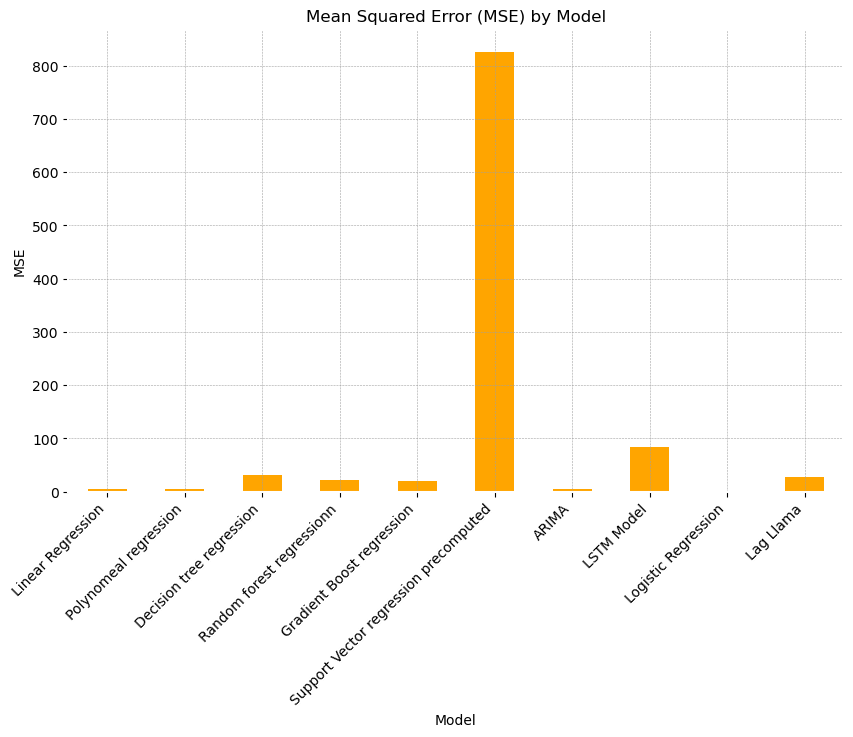

In [112]:
# Bar plot for MSE
plt.figure(figsize=(10, 6))
results_df['mse'].plot(kind='bar', color='orange')
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(rotation=45, ha="right")
plt.show()

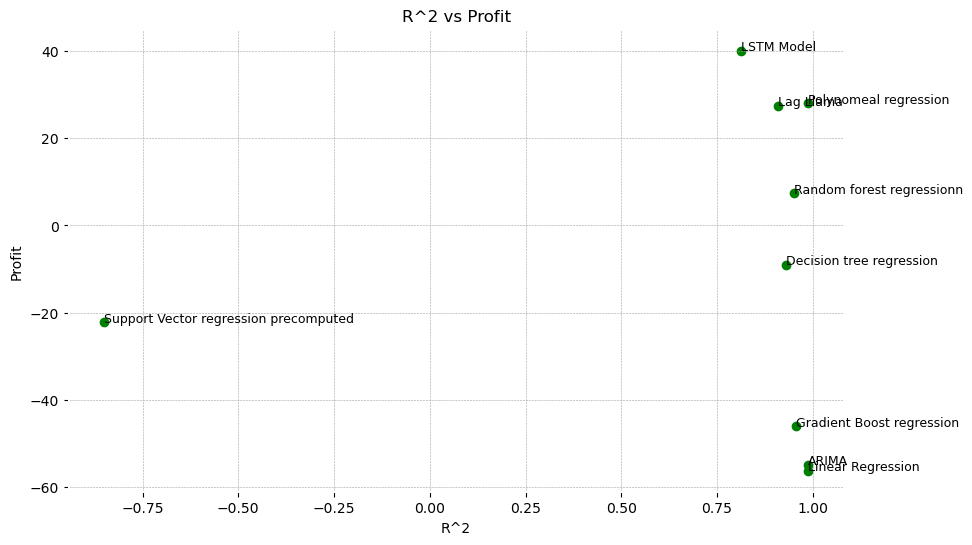

In [113]:
# Scatter plot for R^2 vs Profit
plt.figure(figsize=(10, 6))
plt.scatter(results_df['r2'], results_df['profit'], color='green')
plt.title('R^2 vs Profit')
plt.xlabel('R^2')
plt.ylabel('Profit')
for i, txt in enumerate(results_df.index):
    plt.annotate(txt, (results_df['r2'][i], results_df['profit'][i]), fontsize=9)
plt.show()

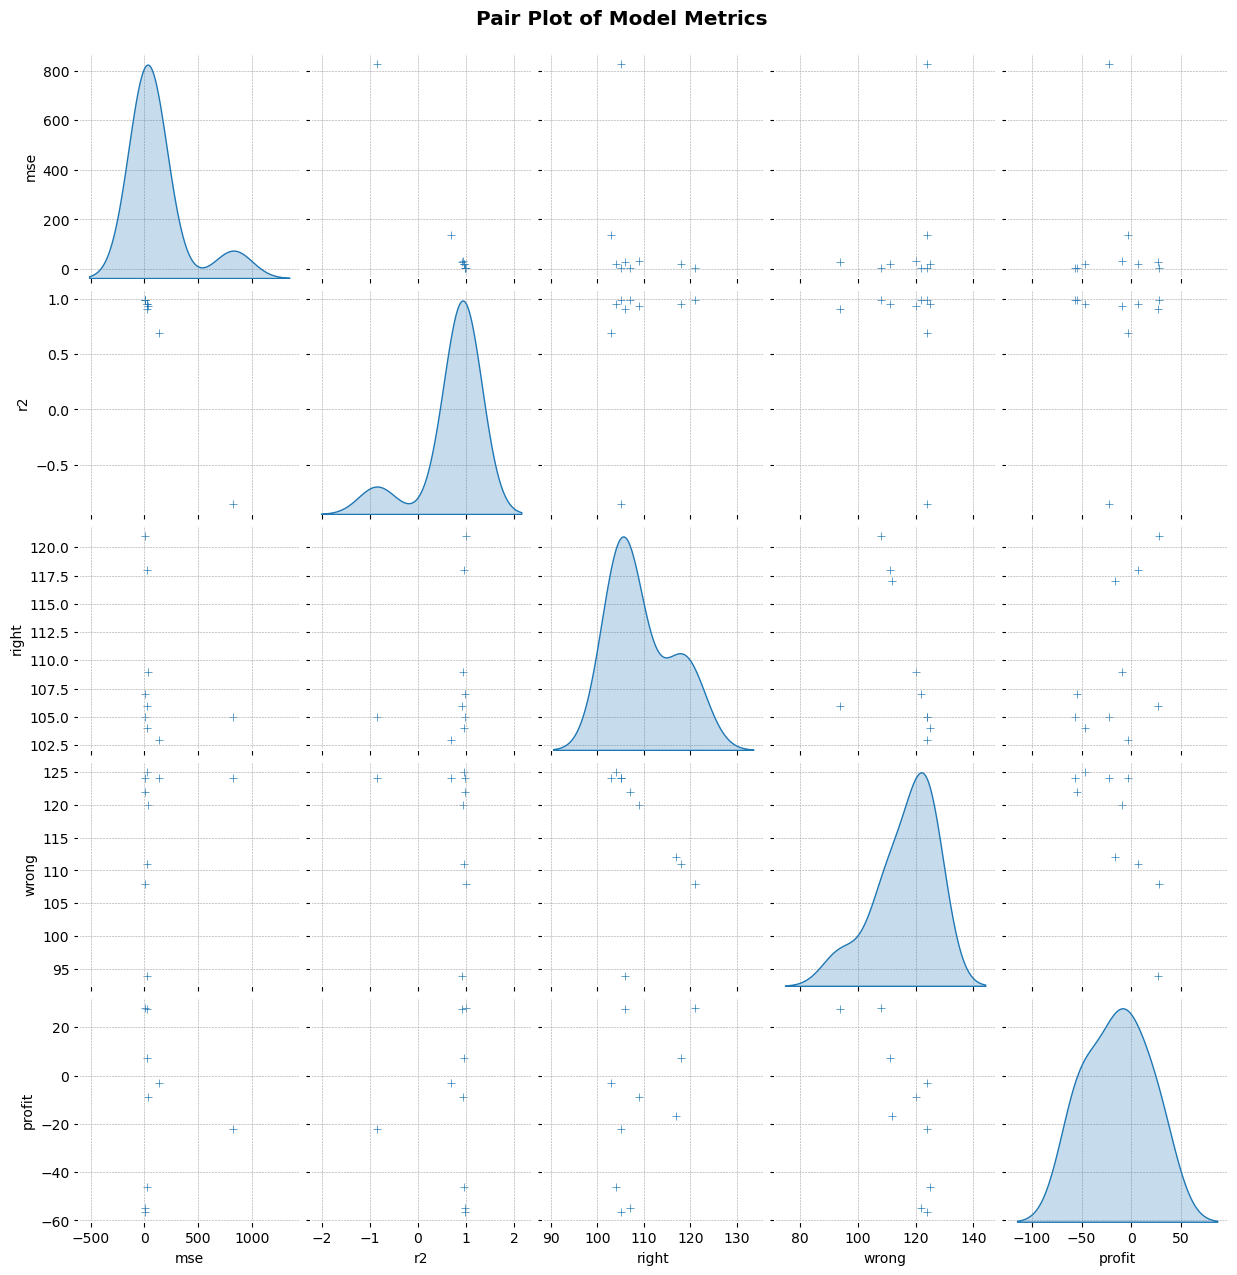

In [91]:
# Pair plot for all numerical columns
sns.pairplot(results_df, diag_kind='kde', markers='+')
plt.suptitle('Pair Plot of Model Metrics', y=1.02)
plt.show()

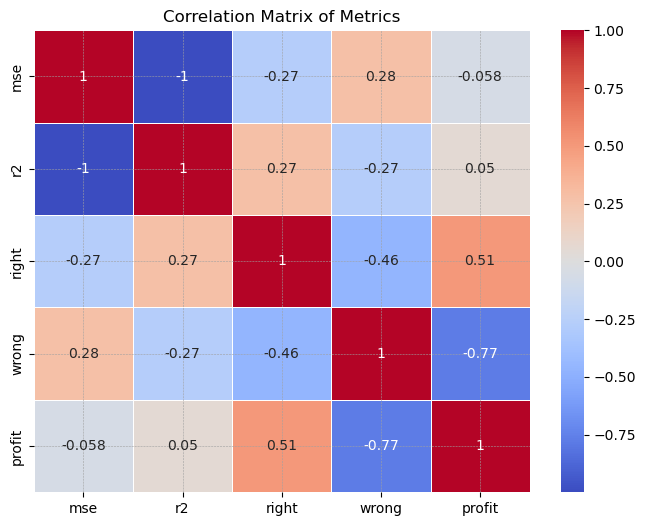

In [92]:
# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(results_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()